In [34]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import os
import random
from tensorflow.keras.applications import MobileNet,MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,BatchNormalization,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adamax
from sklearn.model_selection import train_test_split

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
# Define paths to your train, validation, and test data
train_data_dir = '/content/drive/My Drive/Dataset/train'
validation_data_dir = '/content/drive/My Drive/Dataset/valid'
test_data_dir = '/content/drive/My Drive/Dataset/test'

In [37]:
print("Classes :", os.listdir(train_data_dir))

Classes : ['Autistic', 'Non_Autistic']


In [38]:
def count_image(directory):
    count = 0
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.jpg'):
                count += 1
    return count

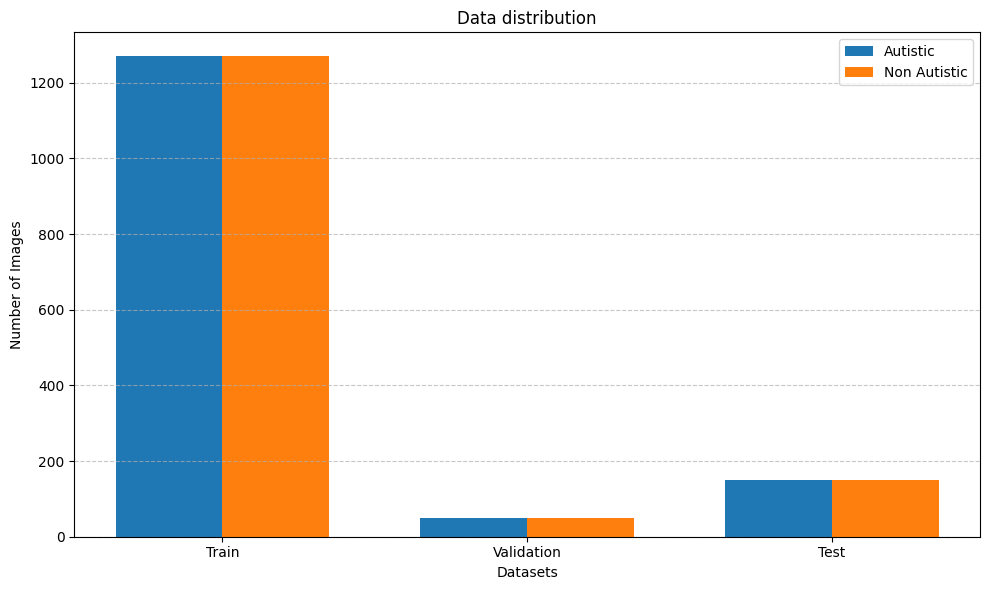

In [39]:
dataset_names = ['Train', 'Validation', 'Test']

Autistic_dataset_counts = [count_image(train_data_dir+'/Autistic'), count_image(validation_data_dir+'/Autistic'), count_image(test_data_dir+'/Autistic')]
Non_Autistic_dataset_counts = [count_image(train_data_dir+'/Non_Autistic'), count_image(validation_data_dir+'/Non_Autistic'), count_image(test_data_dir+'/Non_Autistic')]

plt.figure(figsize=(10, 6))
bar_width = 0.35
indices = range(len(dataset_names))
plt.bar([index - bar_width/2 for index in indices], Autistic_dataset_counts, bar_width, label='Autistic')
plt.bar([index + bar_width/2 for index in indices], Non_Autistic_dataset_counts, bar_width, label='Non Autistic')

plt.xticks(indices, dataset_names)

plt.xlabel('Datasets')
plt.ylabel('Number of Images')
plt.title('Data distribution')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [40]:
# Define image dimensions
img_width, img_height = 224, 224

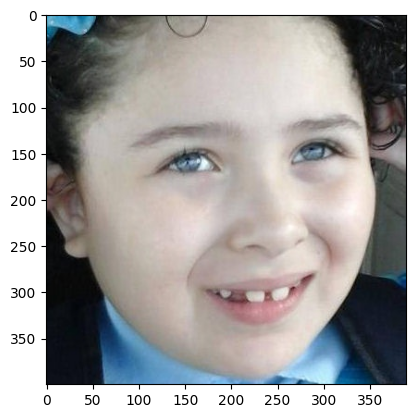

In [41]:
filenames = os.listdir('/content/drive/My Drive/Dataset/train/Autistic')
sample = random.choice(filenames)
image = load_img("/content/drive/My Drive/Dataset/train/Autistic/"+sample)
plt.imshow(image)

In [42]:
# Data augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1. / 255, # image pixels from [0,255] ====> [0,1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest' # Startegy to fill empty pixels after shifting or rotation
)


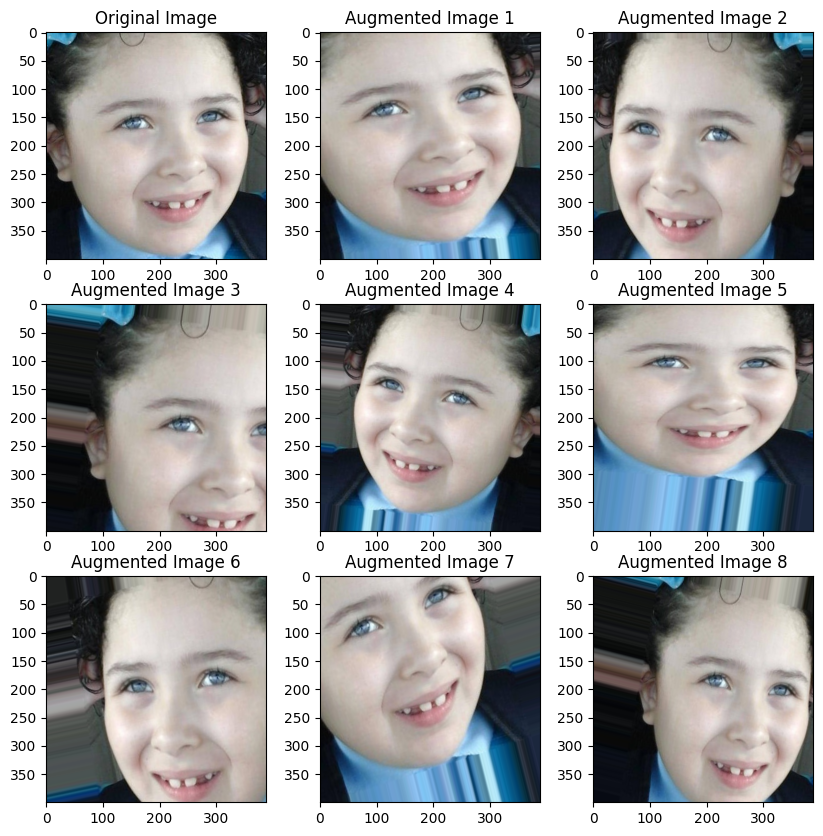

In [43]:
img_array = np.array(image)
img_array = img_array.reshape((1,) + img_array.shape)
augmented_images = train_datagen.flow(img_array, batch_size=1)

# Plot the original image
plt.figure(figsize=(10, 10))
plt.subplot(3, 3, 1)
plt.imshow(image)
plt.title('Original Image')

# Plot augmented images
for i in range(2, 10):
    augmented_image = augmented_images.next()
    plt.subplot(3, 3, i)
    plt.imshow(augmented_image[0])
    plt.title(f'Augmented Image {i-1}')

plt.show()

In [44]:
# Data augmentation for validation and test data
test_datagen = ImageDataGenerator(rescale=1. / 255)

In [45]:
# Data generators
batch_size = 20
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

Found 2540 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [46]:
# Load pre-trained MobileNet without the top classification layer
base_model = MobileNetV2(weights='imagenet', include_top=False,input_shape=(224, 224, 3))
#base_model.summary()

In [47]:
from tensorflow.keras import regularizers
x=base_model.output
x = GlobalAveragePooling2D()(x)
x=BatchNormalization()(x)
x = Dense(1024, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                    bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(0.5)(x)
predictions=Dense(1, activation='sigmoid')(x)

In [48]:
# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)
#model.summary()

In [49]:
# Compile the model
model.compile(optimizer=Adamax(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [50]:
# Define early stopping callback
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

In [51]:
# Train the model
history=model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[early_stopping]
)

Epoch 1/100
127/127 [==============================] - 74s 378ms/step - loss: 20.3326 - accuracy: 0.6417 - val_loss: 19.3892 - val_accuracy: 0.5100
Epoch 2/100
127/127 [==============================] - 47s 368ms/step - loss: 18.3899 - accuracy: 0.7303 - val_loss: 18.4586 - val_accuracy: 0.5700
Epoch 3/100
127/127 [==============================] - 44s 348ms/step - loss: 16.7411 - accuracy: 0.7740 - val_loss: 17.4365 - val_accuracy: 0.5400
Epoch 4/100
127/127 [==============================] - 46s 358ms/step - loss: 15.2620 - accuracy: 0.7819 - val_loss: 16.3220 - val_accuracy: 0.5700
Epoch 5/100
127/127 [==============================] - 44s 346ms/step - loss: 13.8813 - accuracy: 0.8110 - val_loss: 15.0693 - val_accuracy: 0.5700
Epoch 6/100
127/127 [==============================] - 47s 371ms/step - loss: 12.5912 - accuracy: 0.8059 - val_loss: 14.2167 - val_accuracy: 0.5700
Epoch 7/100
127/127 [==============================] - 44s 350ms/step - loss: 11.4067 - accuracy: 0.8165 - val_l

In [59]:
# Evaluate the model
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

loss, accuracy = model.evaluate(test_generator)
print("Test Accuracy:", accuracy)

Found 300 images belonging to 2 classes.
15/15 [==============================] - 2s 95ms/step - loss: 0.5320 - accuracy: 0.8700
Test Accuracy: 0.8700000047683716


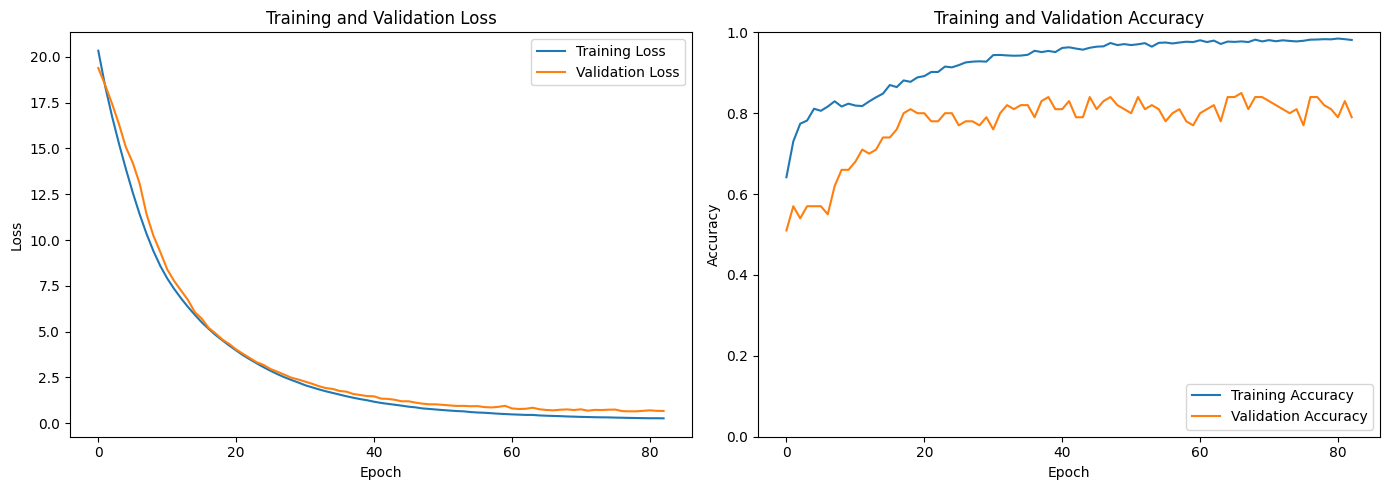

In [60]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Load the test data
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False,
    class_mode='binary'
)

Found 300 images belonging to 2 classes.


In [78]:
# Predict on test data
predictions = model.predict(test_generator)
y_true = test_generator.classes
y_pred = predictions > 0.6  # threshold

15/15 [==============================] - 1s 97ms/step


In [79]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

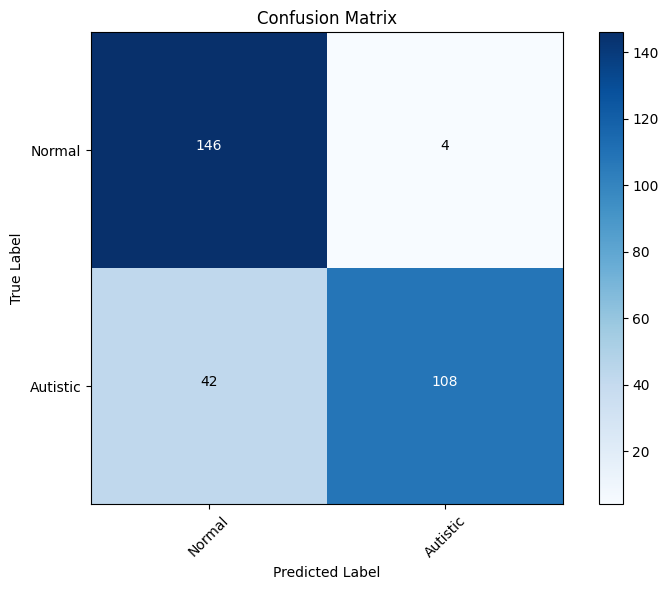

In [80]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Normal', 'Autistic'], rotation=45)
plt.yticks(tick_marks, ['Normal', 'Autistic'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Text annotations
thresh = conf_matrix.max() / 2.
for i, j in ((i, j) for i in range(conf_matrix.shape[0]) for j in range(conf_matrix.shape[1])):
    plt.text(j, i, format(conf_matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

In [81]:
# Extract true negatives, false positives, false negatives, true positives
tn, fp, fn, tp = conf_matrix.ravel()
# Calculate sensitivity and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
print("Sensitivity (True Positive Rate):", sensitivity)
print("Specificity (True Negative Rate):", specificity)

Sensitivity (True Positive Rate): 0.72
Specificity (True Negative Rate): 0.9733333333333334
